## Постановка задачи

Дан набор файлов с аудиозаписью речи в формате .wav, для каждого из которых известен пол говорящего (обучающая выборка). Также дан набор аналогичных файлов, для которых пол говорящего не известен (тестовая выборка).

__Задача__: определить метку пола говорящего для каждого аудиофайла из тестовой выборки с долей верных ответов более 98%.

Наборы данных доступны по ссылкам: [обучение](https://yadi.sk/d/IUUTPJFOfwn_OQ) и [тест](https://yadi.sk/d/K8Z-gQbspmxkhw).

## Инструменты решения
Для запуска проекта потребуются следующие библиотеки для языка python3:
- numpy
- pandas
- torch
- torchaudio
- sklearn
- matplotlib
- tqdm

Для ускорения процесса обучения рекомендуется использовать Nvidia GPU c поддержкой CUDA. 

## Решение

Фиксируем random seed для воспроизводимости результатов.

In [1]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(57575757)

__Задача:__ эффективное представление данных. Файлы в формате .wav нет возможности обрабатывать сами по себе, для начала необходимо извлечь ключевые признаки.

__Решение:__ в первую очередь, файлы в формате .wav считываем ввиде временного ряда записанной звуковой волны (`torchaudio.load`). К такому представлению можно пытаться напрямую применять алгоритмы машинного обучения, но на практике можно применить преобразование Фурье, чтобы получить разложение сигнала на отдельные частоты: так данные становятся более дискретными, что удачно. Полученное представление называется спектрограммой, мы же будем применять мел-спектрограмму (`torchaudio.transforms.MelSpectrogram`), которая отличается от обыкновенной спектрограммы исключительно шкалированием, имитирующее восприятие звуковой волны человеческим ухом.

Данных много, и они занимают большой объем памяти, поэтому могут не поместиться в оперативную память целиком. Для этого в классе `AliceDataset` мы динамически загружаем нужные сэмплы с диска в несколько потоков.

__Задача:__ оценить качество модели, когда нет разметки тестовой выборки.

__Решение:__ разделим размеченные данные на обучающую и валидационную выборку в соотношении 9 к 1. В процессе обучения модель не использует валидационную выборку для подбора параметров.

__Задача:__ что дальше делать с мел-спектрограммой?

__Решение:__ мел-спетрограмма - это матрица, размер которой зависит от частоты дискретизации и длины сэмпла. Зачастую ее визуализирует с помощью двумерного графика heat-map, что хорошо демонстрирует важное свойство: локальность. Для работы с локальными данными мы будем использовать сверточную нейронную сеть - архитектуру, популярную для работы как раз с изображениями.

__Задача:__ мел-спектрограммы имеют разный размер, как с ними работать?

__Решение:__ в рамках одного батча из 160 сэмплов дополним каждую мел-спектрограмму нулями (`torch.nn.utils.rnn.pad_sequence`), чтобы в одном батче данные были одного размера (иначе их нельзя эффективно хранить в памяти). Сами сверточные слои не зависят от фиксированного размера данных (только от фиксированного числа каналов), а вот блок полносвязного классификатора требует матрицы одной формы. Для этого воспользуемся техникой, которая в частности применяется в нейронных сетях ResNet: добавим average pooling слой (`nn.AdaptiveAvgPool2d`), который из матрицы формата $B\times C\times W\times H$ (где $B$ -- размер батча, $C$ -- число каналов, $W$ -- ширина, $H$ -- высота) конструирует матрицу размера $B\times C\times W_1\times H_1$ для произвольных наперед заданных $W_1$ и $H_1$.

In [2]:
import torchaudio
import torchaudio.transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import os
import pandas as pd
from sklearn.model_selection import train_test_split


class AliceDataset(Dataset):
    def __init__(self, folder, transforms=T.MelSpectrogram(n_mels=64), load_targets=True):
        self.folder = folder
        self.transforms = transforms
        self.targets = pd.read_csv(os.path.join(self.folder, 'targets.tsv'), sep='\t', index_col=0, header=None).squeeze() if load_targets else None
        self.files = []
        for filename in os.listdir(folder):
            if filename.endswith('.wav'):
                self.files.append(filename)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filename = self.files[idx]
        audio, _ = torchaudio.load(os.path.join(self.folder, filename))
        target = self.targets.loc[filename.replace('.wav', '')] if self.targets is not None else None
        return self.transforms(audio), target

def collate_fn(batch):
    return pad_sequence([item[0].permute(2, 1, 0) for item in batch], batch_first=True).permute(0, 3, 2, 1), torch.tensor([item[1] for item in batch]) if batch[0][1] is not None else None

train_dataset = AliceDataset('train')
train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.1, shuffle=True, stratify=train_dataset.targets)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dataloader = DataLoader(train_dataset, pin_memory=True, num_workers=8, batch_size=160, collate_fn=collate_fn, sampler=train_sampler)
val_dataloader = DataLoader(train_dataset, pin_memory=True, num_workers=8, batch_size=160, collate_fn=collate_fn, sampler=val_sampler)
test_dataset = AliceDataset('test', load_targets=False)
test_dataloader = DataLoader(test_dataset, pin_memory=True, num_workers=8, batch_size=160, collate_fn=collate_fn)

## Структура сети
На данной задаче хорошие результаты показывает классическая архитектура CNN, вдохновленная ResNet. Последовательно применяется 5 сверточных блоков, average pooling и перцептрон для классификации, с несколькими нелинейностями типа ReLU и Tanh, а также Dropout слой для предотвращения переобучения.

In [3]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),            
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),            
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),            
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128),            
        )
        
        self.block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(256),            
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Dropout(0.35),
            nn.Linear(256, 2)
        )    

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return self.classifier(x)

In [4]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    losses = []
    progress_bar = tqdm.notebook.tqdm(train_dataloader)
    model.to(device).train()
    for (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.detach())
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_description(f'Train loss = {loss.item():.4f}')
    return torch.cat(losses).cpu()

def eval_one_epoch(model, val_dataloder, criterion, device="cuda:0"):
    predicted_classes = []
    true_classes = []
    losses = []
    progress_bar = tqdm.notebook.tqdm(val_dataloader)
    model.to(device).eval()
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss)
            loss = loss.mean()
            predicted_classes.append(outputs.argmax(dim=1))
            true_classes.append(labels)
            progress_bar.set_description(f'Val loss = {loss.item():.4f}')
    return torch.cat(losses).cpu(), torch.cat(predicted_classes).cpu(), torch.cat(true_classes).cpu()


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    best_accuracy = 0
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_losses_ = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        train_losses.append(train_losses_.mean())
        val_losses_, val_predicted_classes, val_true_classes = eval_one_epoch(model, val_dataloader, criterion, device)
        val_losses.append(val_losses_.mean())
        last_accuracy = accuracy_score(val_true_classes, val_predicted_classes)
        best_accuracy = max(best_accuracy, last_accuracy)
        clear_output(wait=True)
        if scheduler is not None:
            scheduler.step(last_accuracy)
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.legend()
        plt.title(f'Cross Entropy Loss on epoch {epoch}')
        plt.show()
        print(f'Last val accuracy = {last_accuracy}')
        print(f'Best val accuracy = {best_accuracy}')

Для задачи классификации логично использовать кросс энтропию (`nn.CrossEntropyLoss`) в качестве функции потерь. Для улучшения результатов модели мы также будем использовать scheduler, который уменьшает learning rate оптимизатора, если доля верных ответов на валидационной выборке долго не растет. Это позволяет быстрее и точнее подобрать параметры, не жертвуя чем-то одним. У оптимизатора `AdamW` также указываем параметр l2-регуляризации `weight_decay` для предотвращения переобучения. В процессе будем строить график значения функции потерь на обучающей и тестовой выборке, а также логировать долю верных ответов на валидационной выборке.

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using device: {device}')
model = CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, cooldown=2, threshold=1e-2, threshold_mode='abs', min_lr=1e-6, verbose=True)
n_epochs = 15

Using device: cuda:0


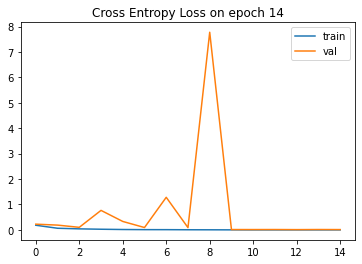

Last val accuracy = 0.996413199426112
Best val accuracy = 0.9971305595408895


In [6]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Предскажем метки тестовой выборки и сохраним их в файл `test_targets.tsv`.

In [7]:
def predict(model, test_dataloder, criterion, device="cuda:0"):
    predicted_classes = []
    progress_bar = tqdm.notebook.tqdm(test_dataloader)
    model.to(device).eval()
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted_classes.append(outputs.argmax(dim=1))
    return torch.cat(predicted_classes).cpu()

pred = predict(model, test_dataloader, criterion, device)
pd.Series(pred, index=map(lambda s: s.replace('.wav', ''), test_dataset.files)).to_csv('test_targets.tsv', sep='\t', header=None)

  0%|          | 0/22 [00:00<?, ?it/s]

Сохраняем модель:

In [13]:
model.cpu()
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')

## Результаты
На валиадационной выборке доля верных ответов превышает 99%. К разметке тестовой выборки у меня нет доступа, но автоматическая тестирующая система подтверждает, что задача выполнена успешно, то есть доля верных ответов на тестовой выборке как минимум 98%.